In [26]:
import numpy as np
import matplotlib.pyplot as plt
import time as time_lib

import multiprocessing

from scripts.dynamics import vecField
from scripts.plotting import plot_results
from scripts.ode_solvers import solver
from scripts.parareal import parallel_solver

In [27]:
system = "Burger"
nodes = "uniform"
n_x = 5

LB = -1.
UB = 1.
L = 5

vecRef = vecField(system=system)

if system=="Rober":
        k1,k2,k3 = vecRef.k1,vecRef.k2,vecRef.k3
        t_max = 100.
        num_t = 101
        L = 3
        n_t = 2
        vecRef.dt_fine = 1e-4
elif system=="SIR":
        beta,gamma,N = vecRef.beta,vecRef.gamma,vecRef.N
        t_max = 100.
        num_t = 101
        L = 5
        n_t = 2
        vecRef.dt_fine = 1e-2
elif system=="Brusselator":
        A,B = vecRef.A,vecRef.B 
        t_max = 12.
        num_t = 32
        L = 5
        n_t = 5
        vecRef.dt_fine = t_max/700
elif system=="Arenstorf":
        a,b = vecRef.a,vecRef.b 
        t_max = 17#17.0652165601579625588917206249 #One period
        num_t = 51
        n_x = 5
        L = 3
        n_t = 2
        vecRef.dt_fine = t_max / 80000
elif system=="Lorenz":
        sigma,r,b = vecRef.sigma,vecRef.r,vecRef.b
        t_max = 10.
        num_t = 21
        L = 3
        n_t = 5
        vecRef.dt_fine = t_max / 14400
elif system=="Burger":
        L = 3
        nu = vecRef.nu
        dx = vecRef.dx
        x = vecRef.x
        t_max = 1.
        num_t = 2
        n_t = 21
        vecRef.dt_fine = t_max / 100
else:
        print("Dynamics not implemented")

weight = np.random.uniform(low=LB,high=UB,size=(L))
bias = np.random.uniform(low=LB,high=UB,size=(L))
      
time = np.linspace(0,t_max,num_t)
dts = np.diff(time)

#### Setting the initial conditions

In [28]:
if system=="Rober":
        y0 = np.array([1.,0.,0])
elif system=="SIR":
        y0 = np.array([0.3,0.5,0.2])
elif system=="Brusselator":
        y0 = np.array([0.,1.])
elif system=="Arenstorf":
        y0 = np.array([0.994,0,0.,-2.00158510637908252240537862224])
elif system=="Lorenz":
        y0 = np.array([20.,5,-5])
elif system=="Burger":
        #y0 = np.sin(2*np.pi*vecRef.x)
        #y0 = np.sin(2*np.pi*vecRef.x) + np.cos(4*np.pi*vecRef.x) - np.cos(8*np.pi*vecRef.x) 
        y0 = vecRef.x*(1.-vecRef.x)
else:
        print("Dynamics not implemented")

In [29]:
data = {"LB" : LB,
        "UB" : UB,
        "L" : L,
        "y0" : y0,
        "weight" : weight,
        "bias" : bias,
        "n_x" : n_x,
        "n_t" : n_t,
        "system" : system,
        "nodes" : nodes,
        "act_name" : "tanh"}

In [30]:
num_processors_list = [1]
computational_times = []
overheads = []
used_processors = []
for number_processors in num_processors_list:
    print(f"Experiment with {number_processors} processors")
    coarse_approx,networks, total_time, number_processors = parallel_solver(time,data,dts,vecRef,number_processors,verbose=True)
    used_processors.append(number_processors)
    #overheads.append(overhead_costs)
    computational_times.append(total_time)

Experiment with 1 processors
Iterate 1 completed
Time for iterate 1 is 5.361076354980469
Iniziato iterazione 2
Time required for the fine solver :  1.0524530410766602
Difference norms :  [0.001530455764991865]
Maximum norm of difference : 0.0015304558
Finito iterazione 2
Iterate 2 completed
Time for iterate 2 is 1.9257798194885254
Iniziato iterazione 3
Time required for the fine solver :  1.248586893081665
Difference norms :  [2.3186820167622647e-10]
Maximum norm of difference : 2e-10
Finito iterazione 3
Iterate 3 completed
Time for iterate 3 is 2.226931095123291


In [31]:
if len(num_processors_list)>1:
    fig = plt.figure(dpi=600)
    plt.plot(num_processors_list,computational_times,'ko')
    plt.xlabel("Number of processors")
    plt.ylabel("Computational time")
    plt.savefig(f"savedPlots/comparison_costVSprocessors_{system}.pdf")
    
    for i in range(len(num_processors_list)):
        plt.plot(num_processors_list[i],overheads[i],'r-o')
    plt.title("Overhead costs")
    plt.xlabel("Number processors")
    plt.ylabel("Cost")

In [32]:
def get_detailed_solution():
    num_steps = int((networks[0].dt / vecRef.dt_fine))
    print(num_steps)
    time_plot = np.linspace(0,networks[0].dt,num_steps+1)
    sol = networks[0].plotOverTimeRange(time_plot)
    total_time = time_plot
    for i in np.arange(1,len(networks)):
        num_steps = int((networks[i].dt / vecRef.dt_fine))
        time_plot = np.linspace(0,networks[i].dt,num_steps)[1:]
        sol = np.concatenate((sol,networks[i].plotOverTimeRange(time_plot)),axis=1)
        total_time = np.concatenate((total_time,time_plot+total_time[-1]),axis=0)
    return sol,total_time

In [33]:
network_sol, time_plot = get_detailed_solution()

100


In [34]:
num_fine_steps_per_coarse = ( t_max / (num_t-1) ) / vecRef.dt_fine
num_fine_steps = t_max / vecRef.dt_fine

In [35]:
initial = time_lib.time()
arg = [[y0,time_plot[-1],time_plot],vecRef]
output,time_plot_sequential = solver(arg,final=False)
final = time_lib.time()
print(f"Computational time sequential: {final-initial}")
print(f"Computational time parallel with {number_processors} processors: {total_time}")
#print(f"Average cost one coarse step: {average_coarse_cost}")
print(f"Average cost fine steps to cover one coarse step: {total_time / num_fine_steps * num_fine_steps_per_coarse}")

Computational time sequential: 1.034026861190796
Computational time parallel with 1 processors: 9.514089107513428
Average cost fine steps to cover one coarse step: 9.514089107513428


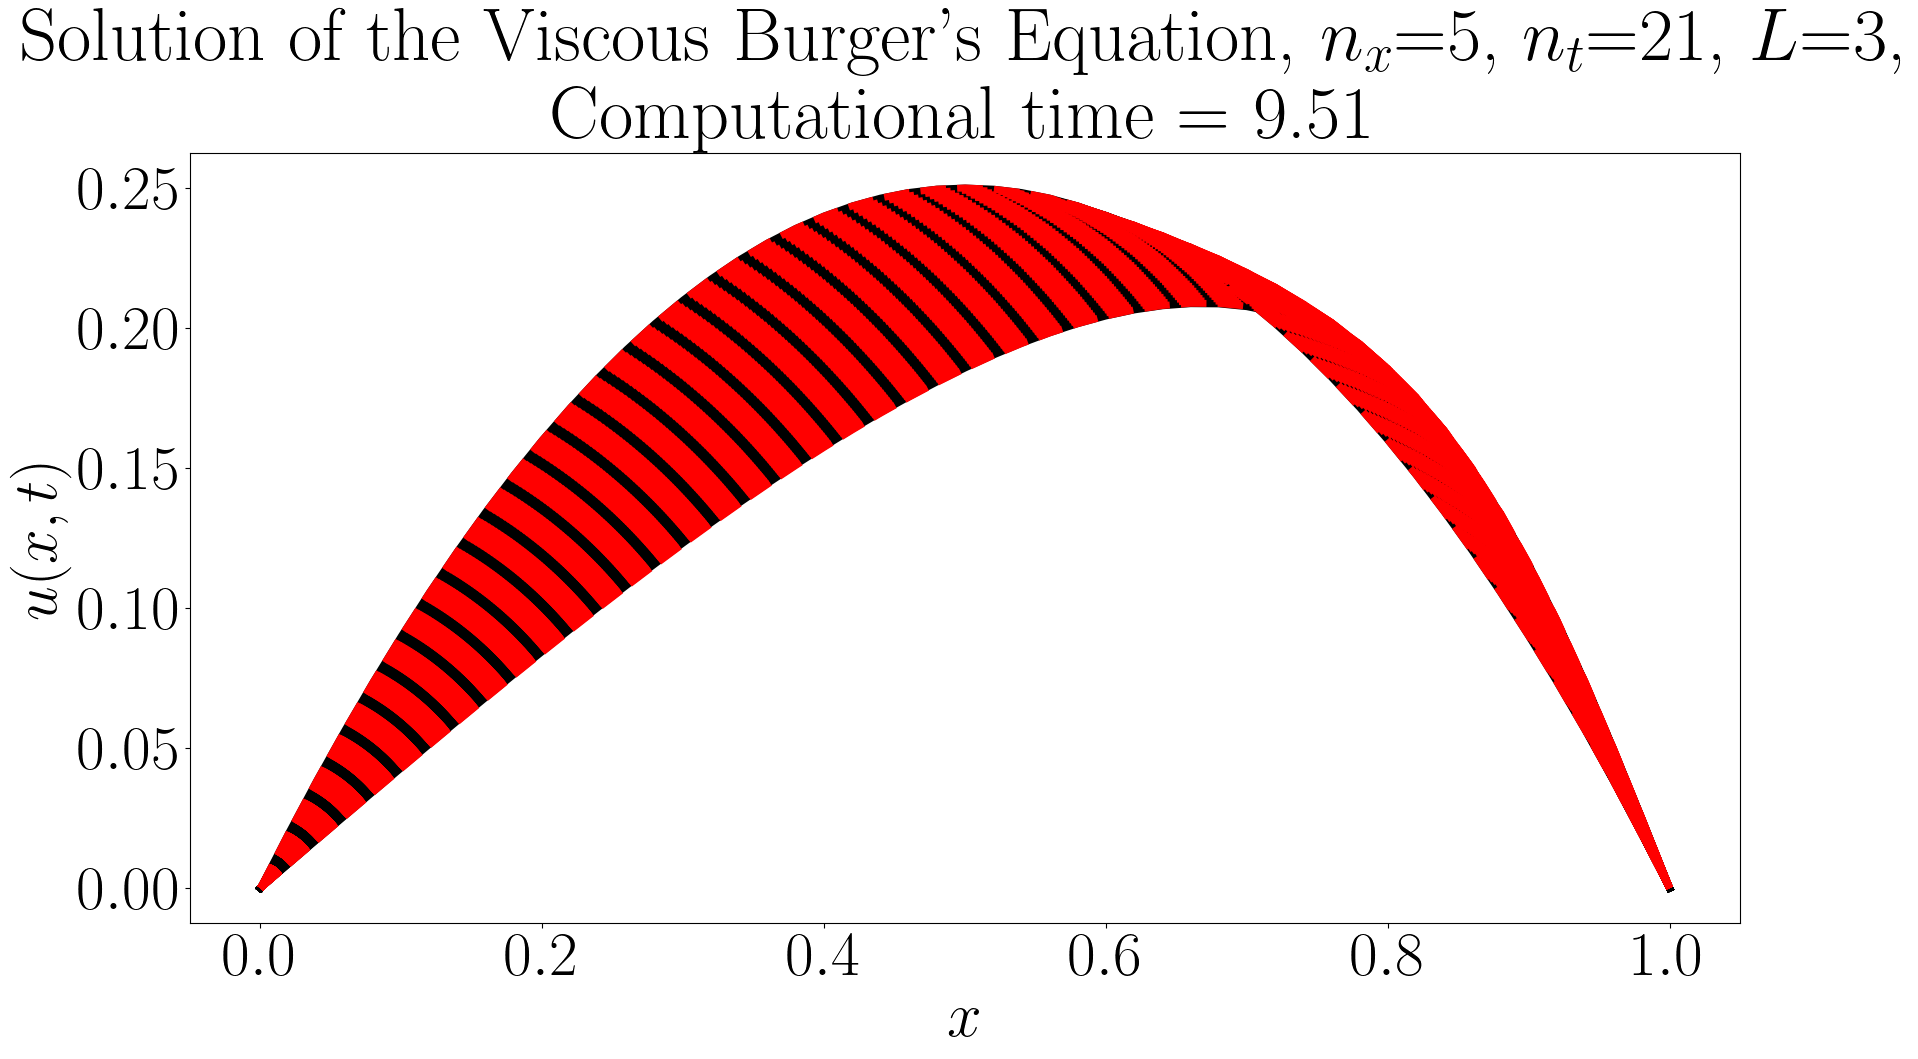

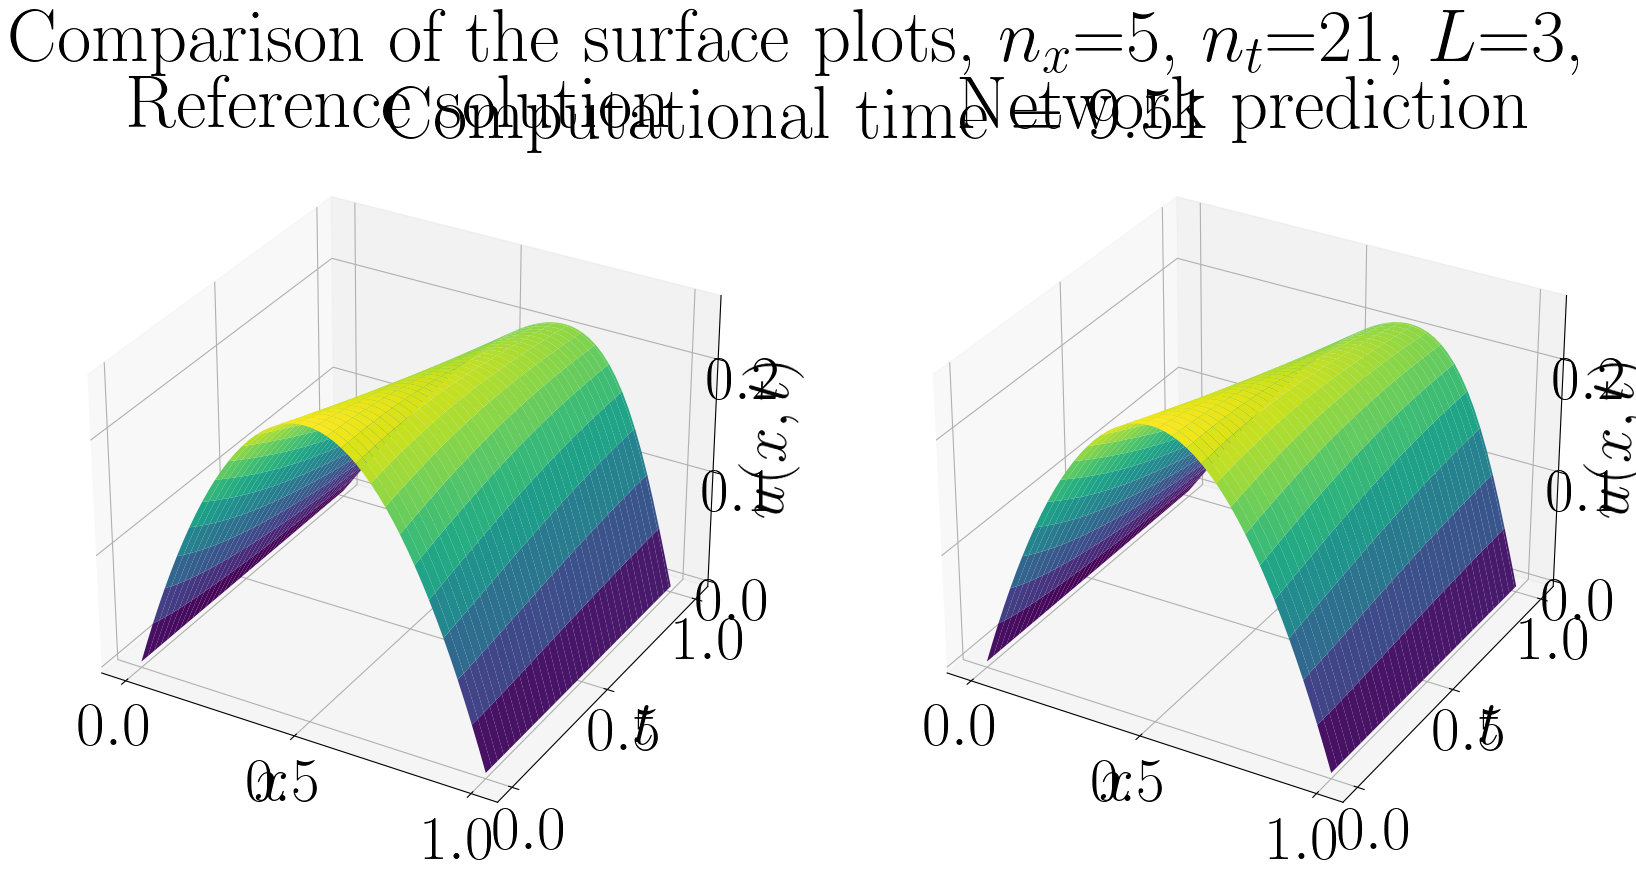

In [36]:
if len(y0)==2:
    list_of_labels = [r"$x$",r"$y$"]
elif len(y0)==3:
    list_of_labels = [r"$x$",r"$y$",r"$z$"]
elif len(y0)==4:
    list_of_labels = [r"$x$",r"$\dot{x}$",r"$y$",r"$\dot{y}$"]
else:
    list_of_labels = []
plot_results(y0,coarse_approx,networks,system,time_plot,time_plot_sequential,output,network_sol,list_of_labels,total_time,time,n_x,n_t,L,vecRef)

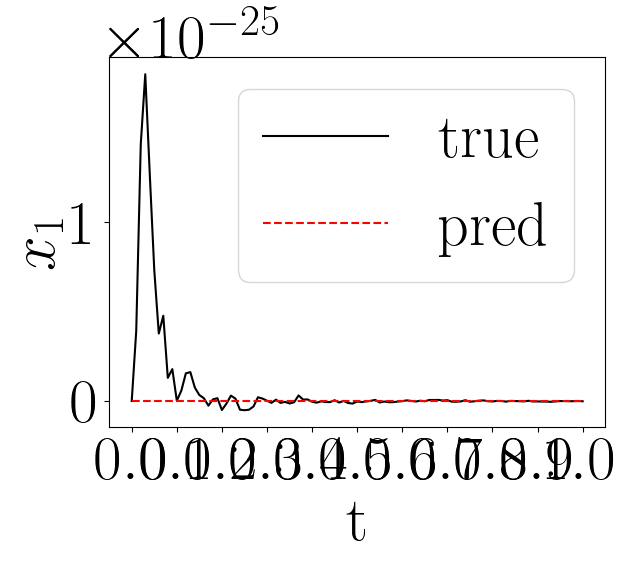

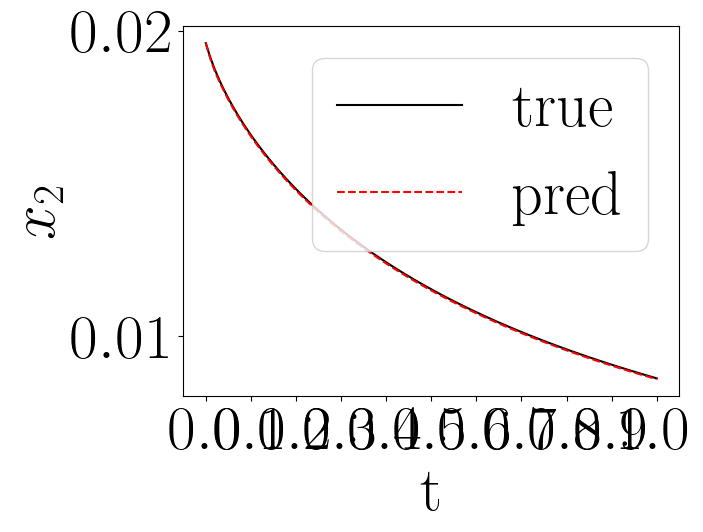

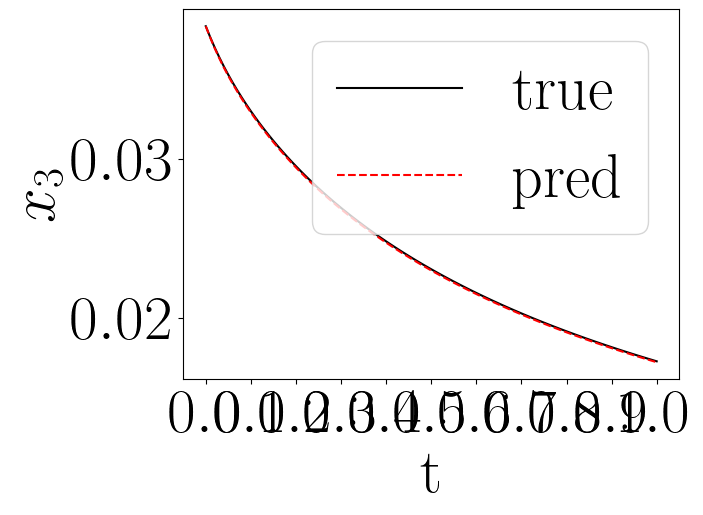

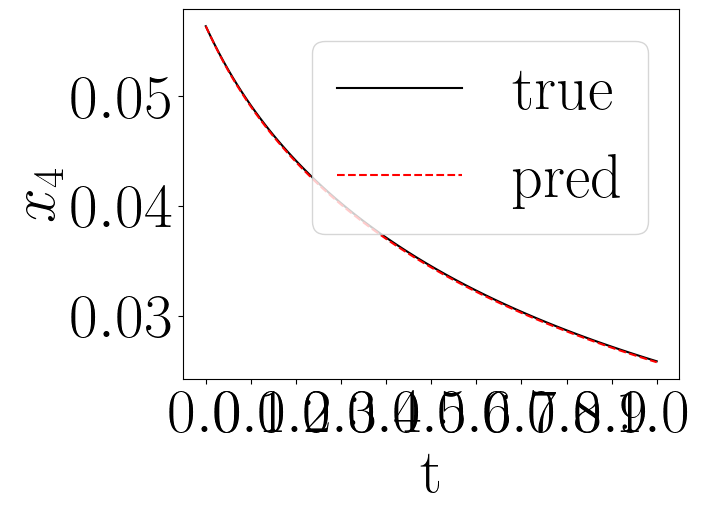

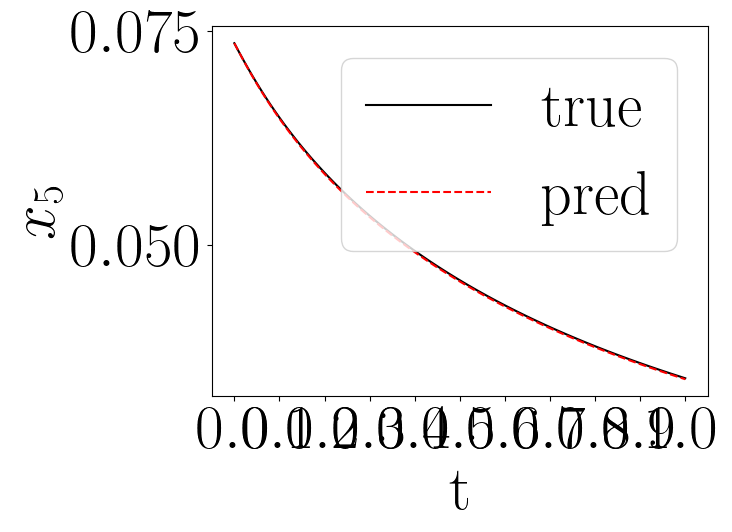

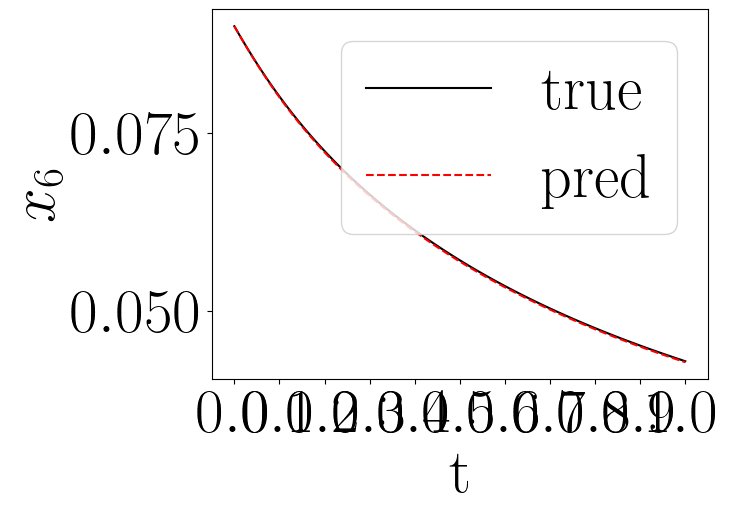

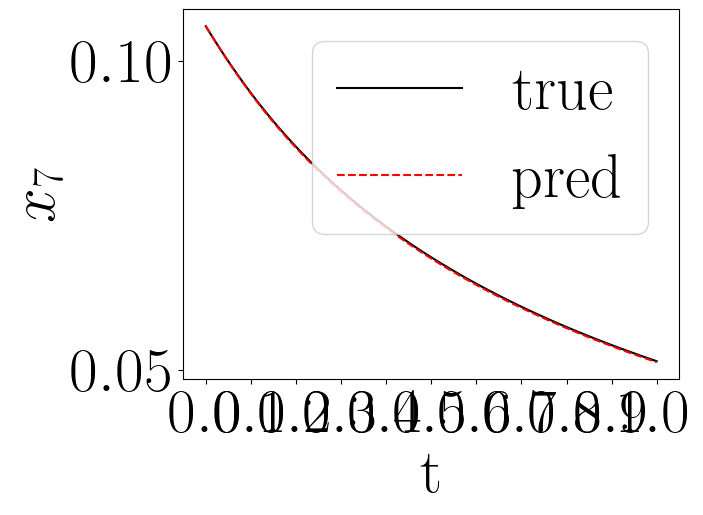

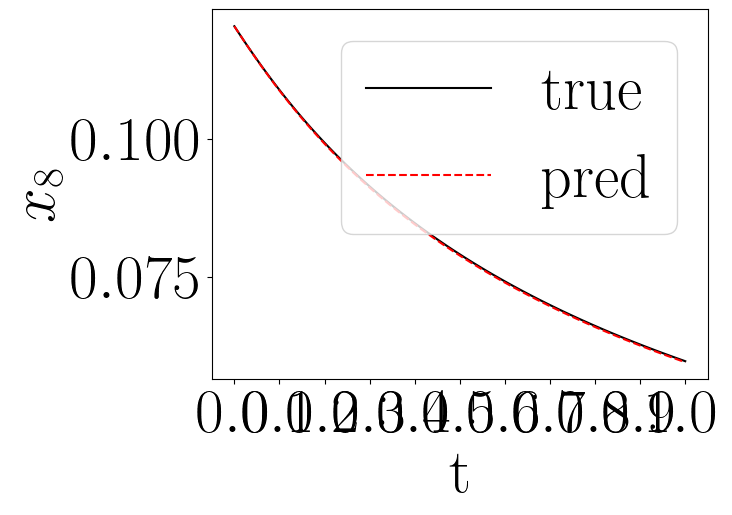

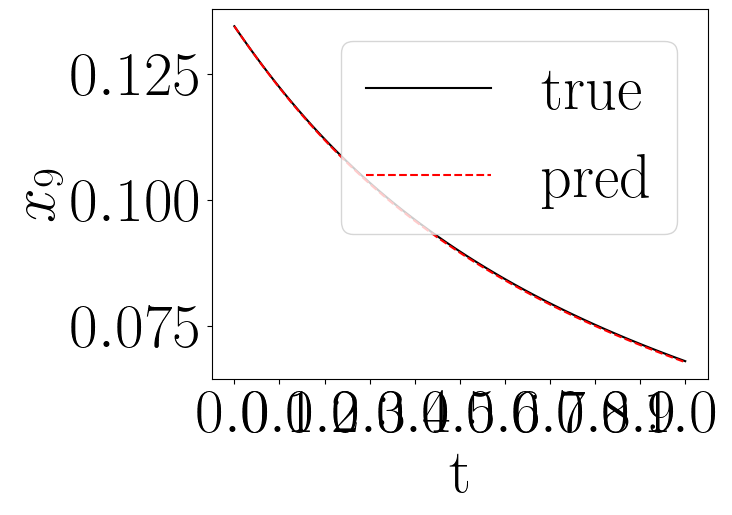

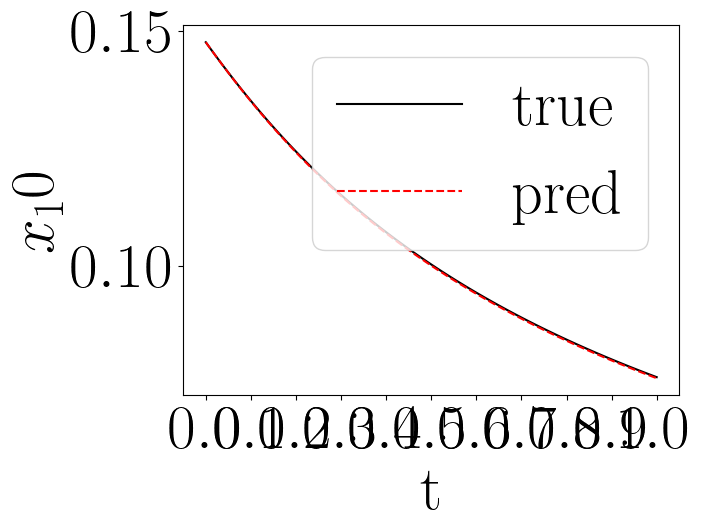

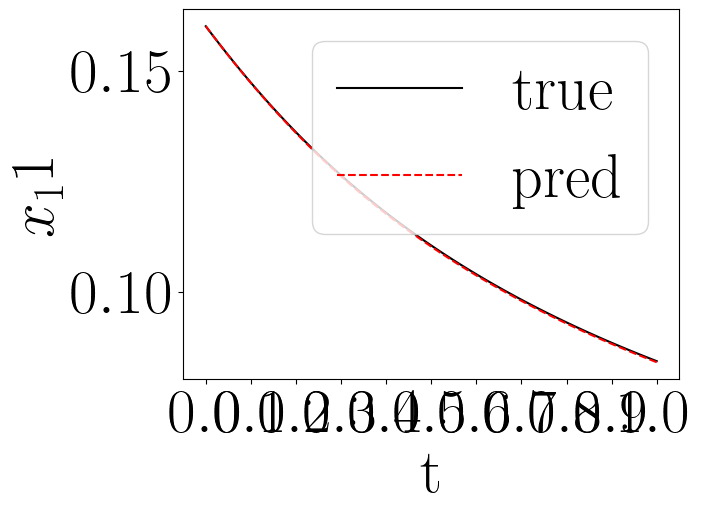

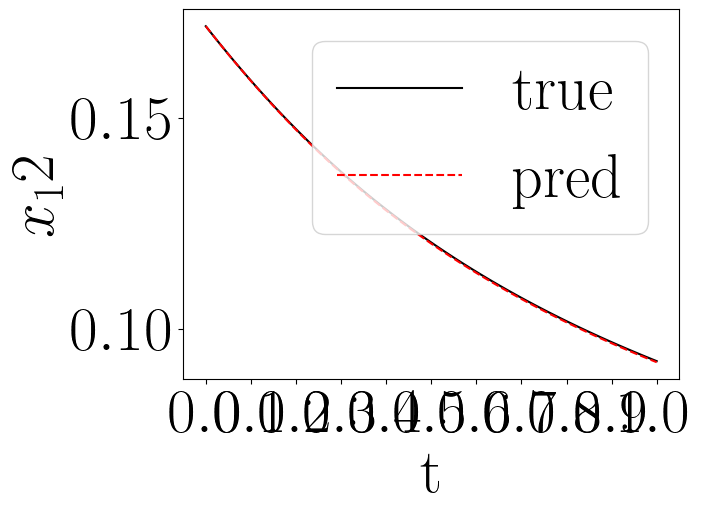

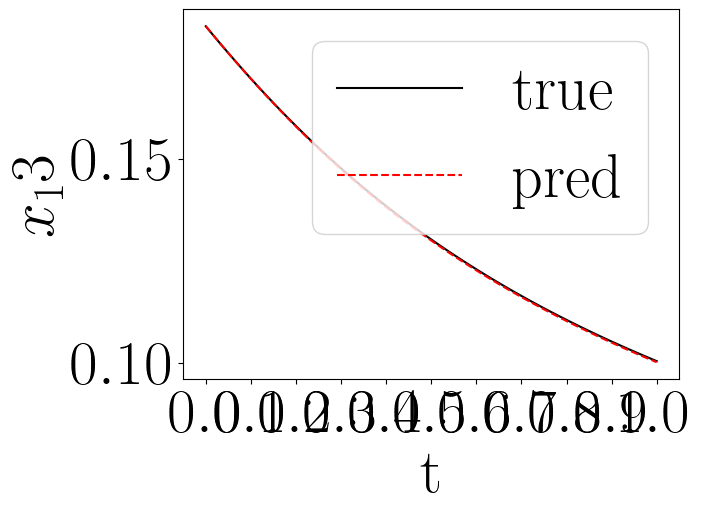

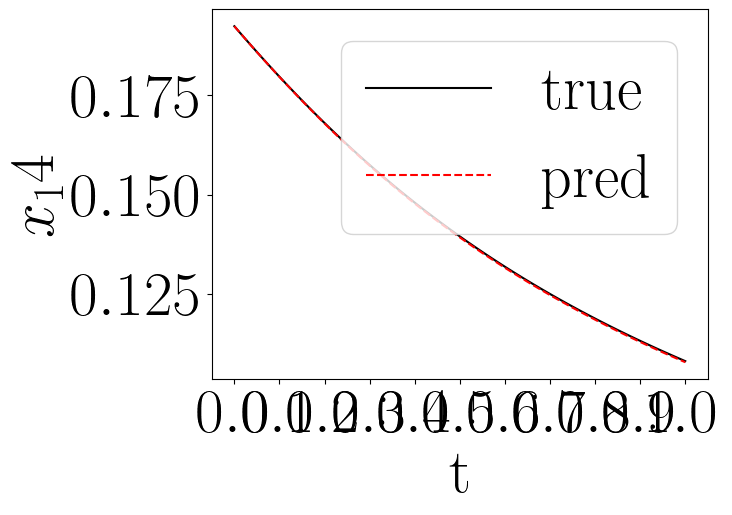

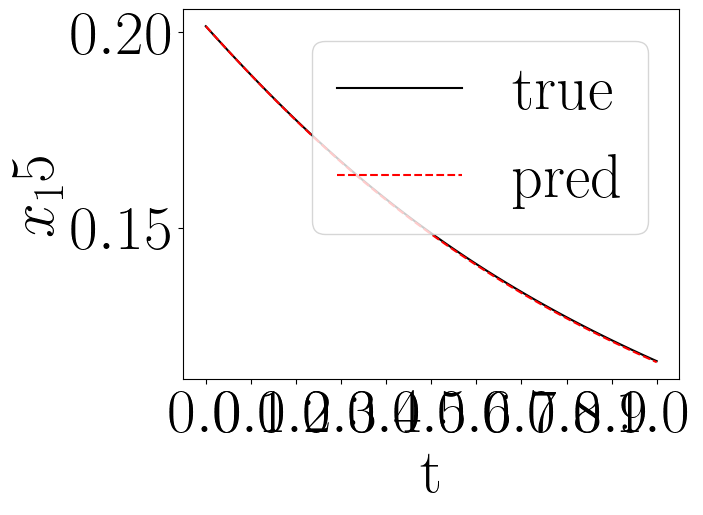

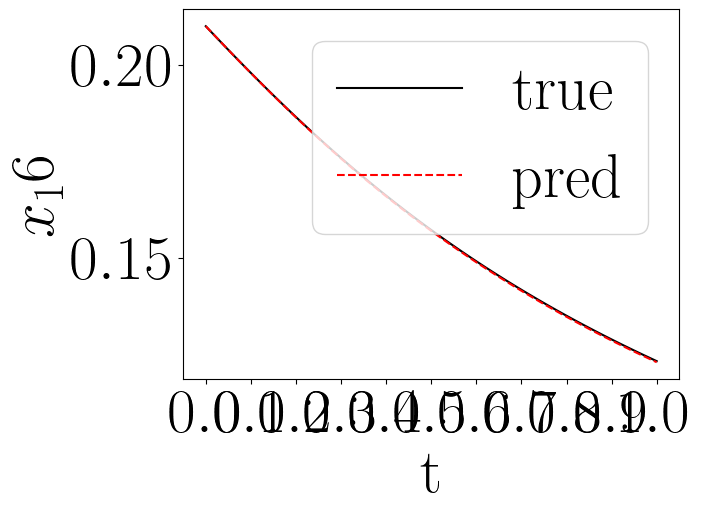

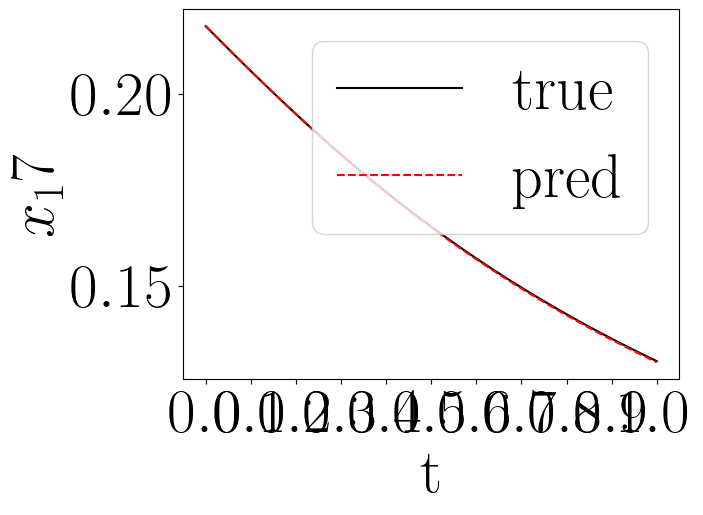

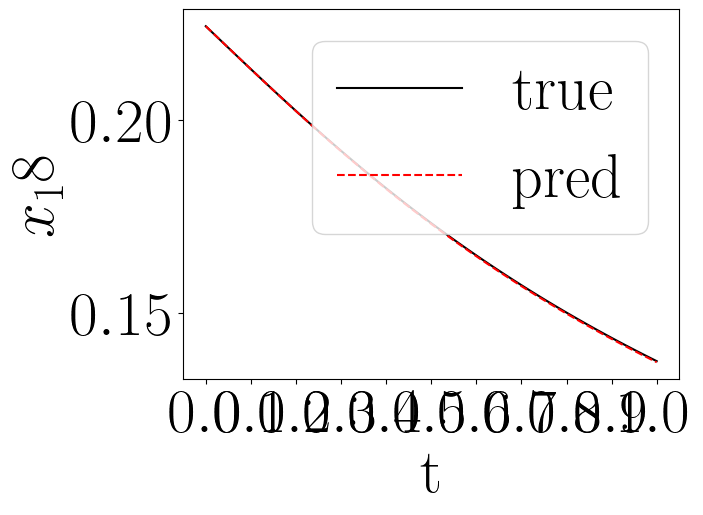

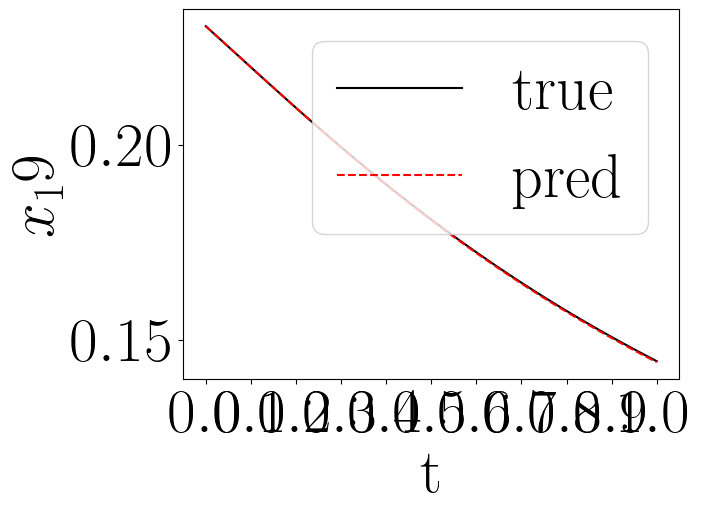

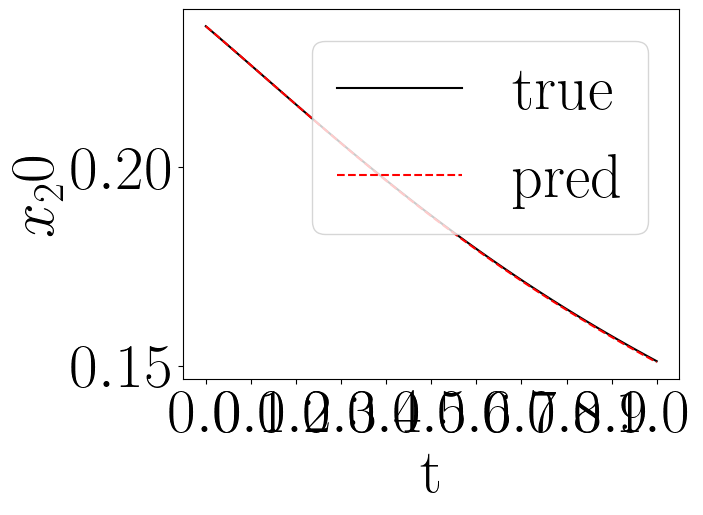

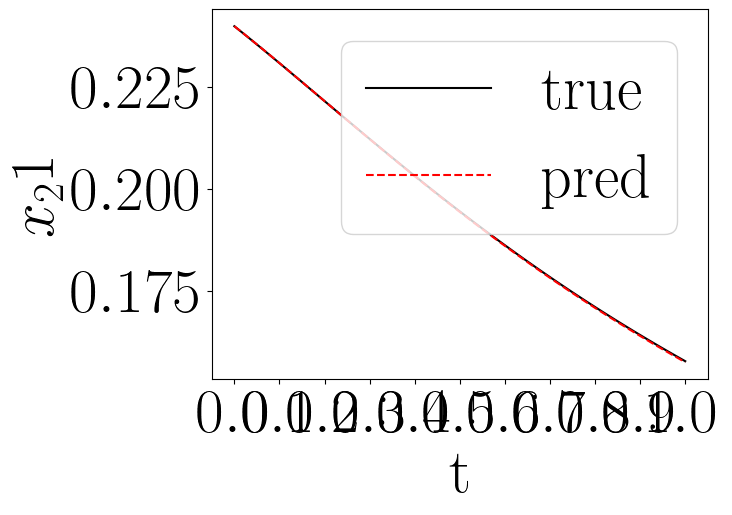

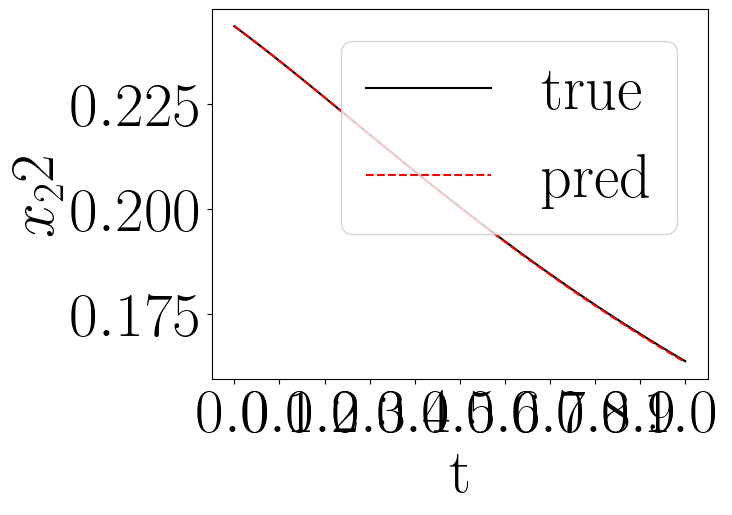

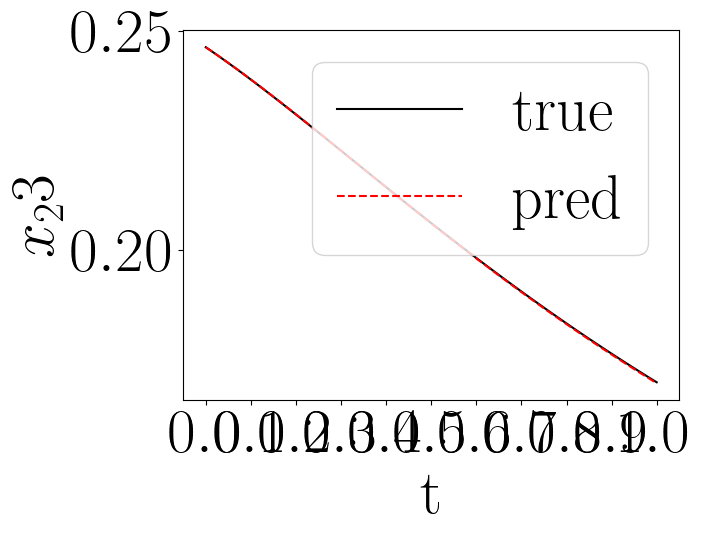

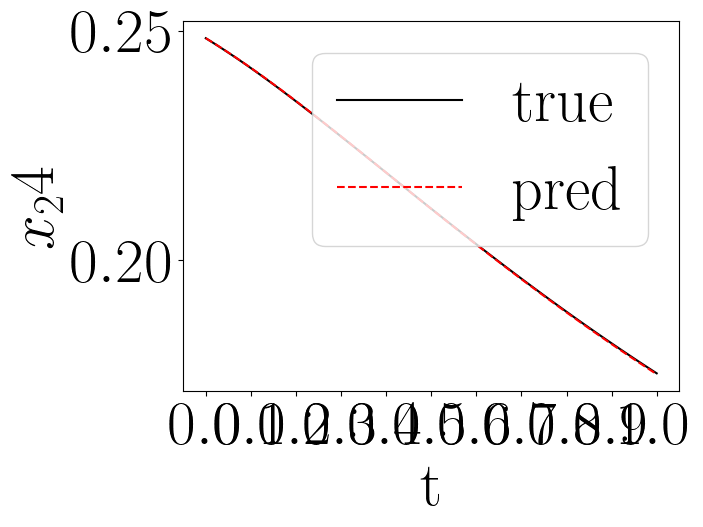

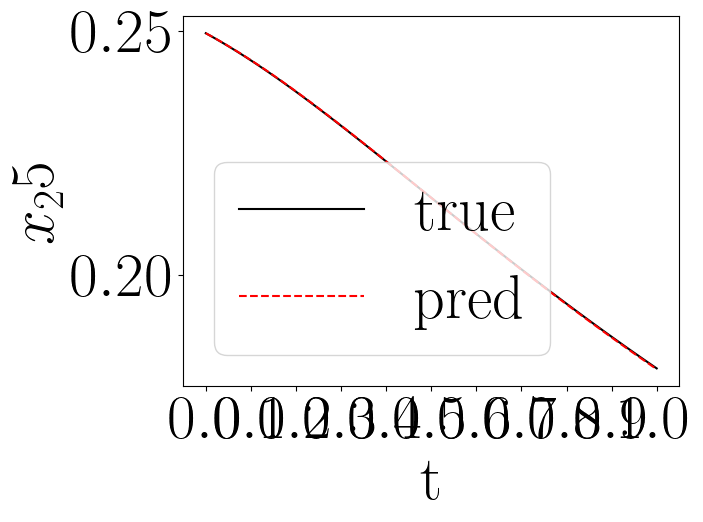

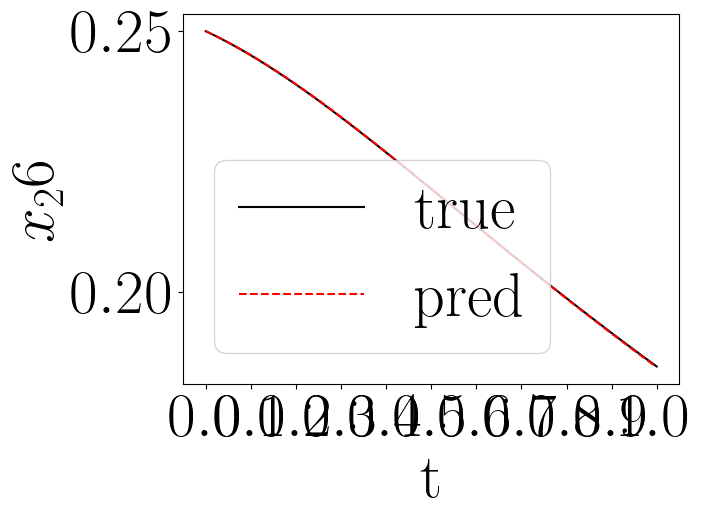

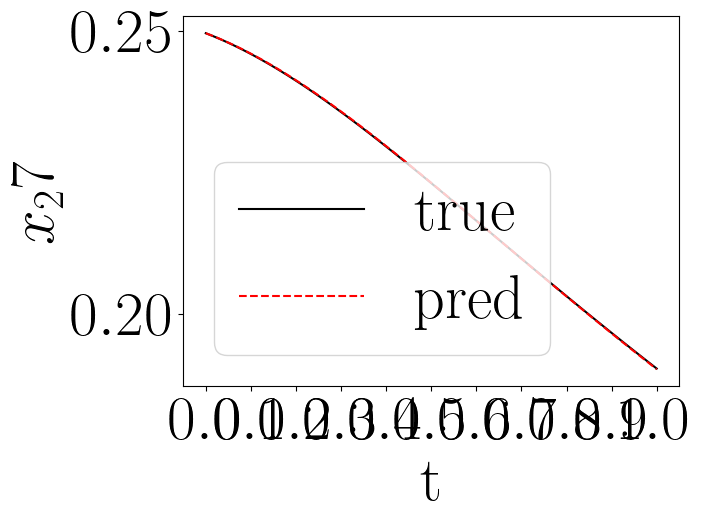

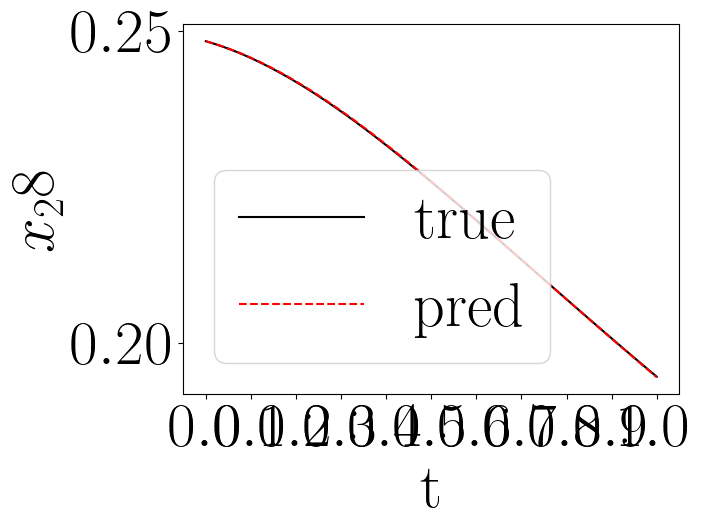

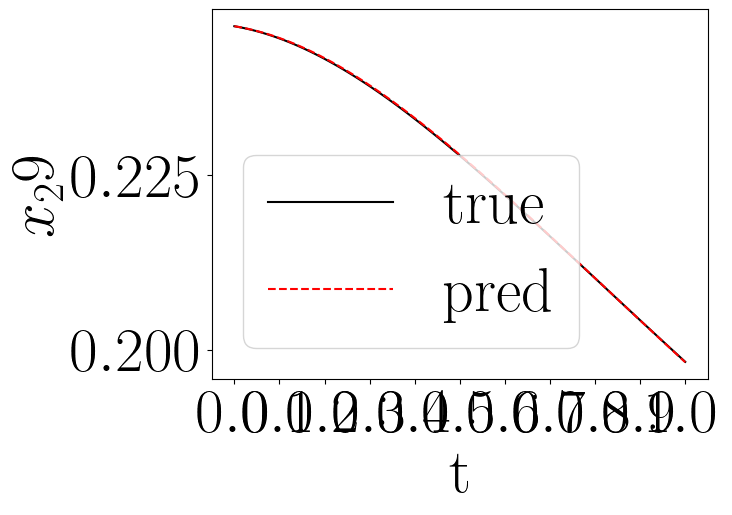

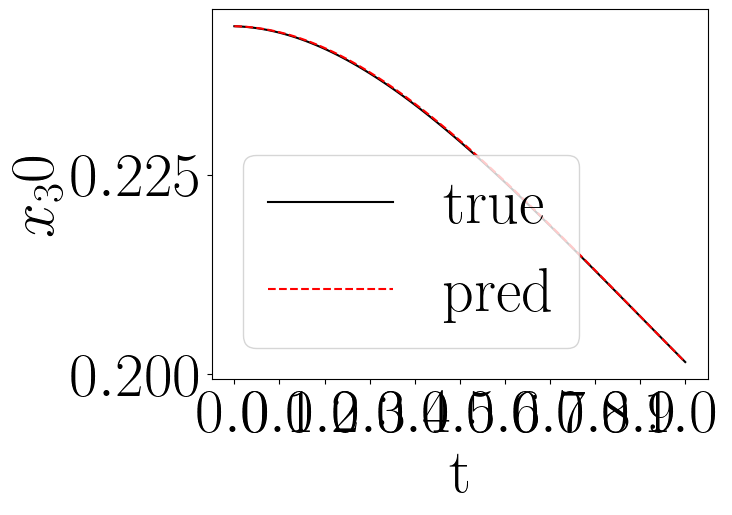

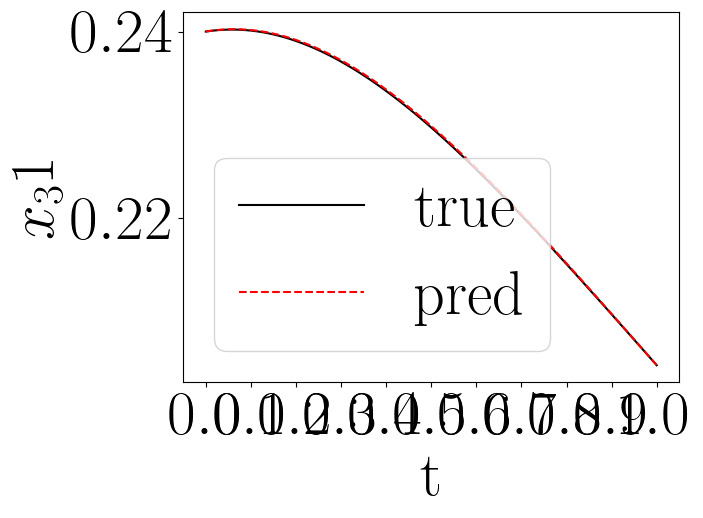

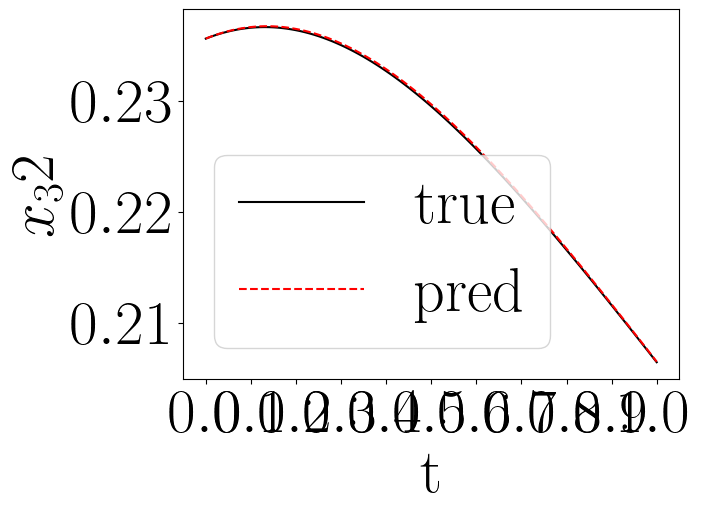

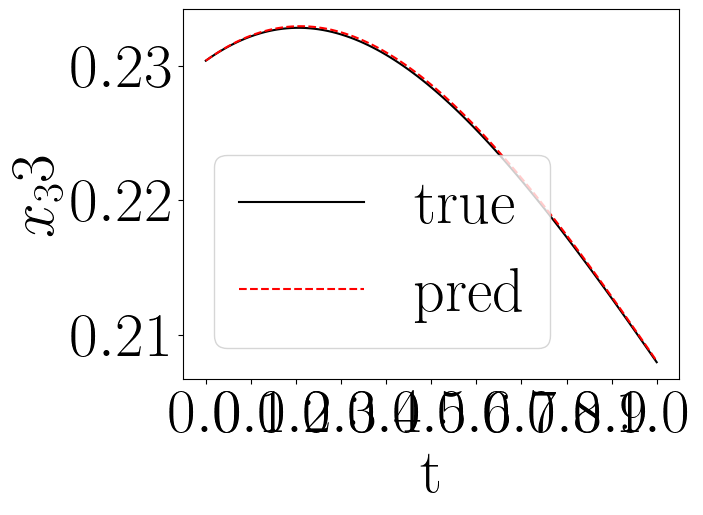

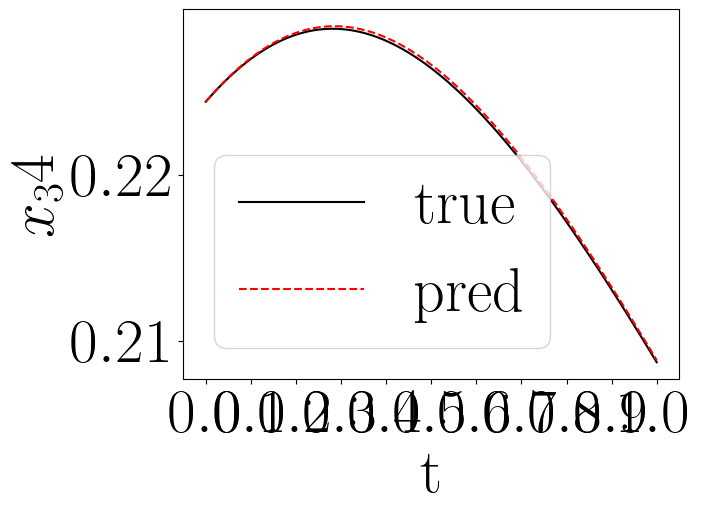

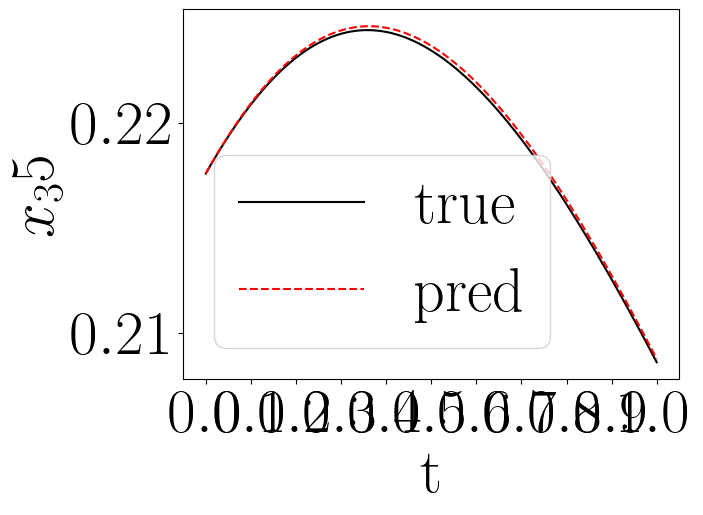

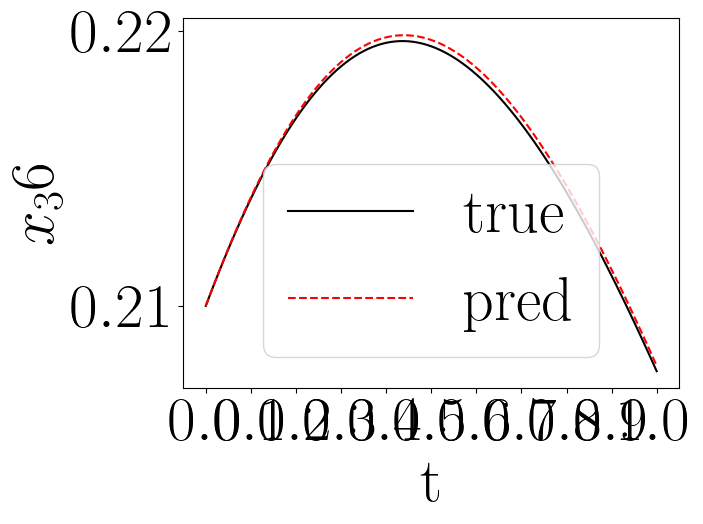

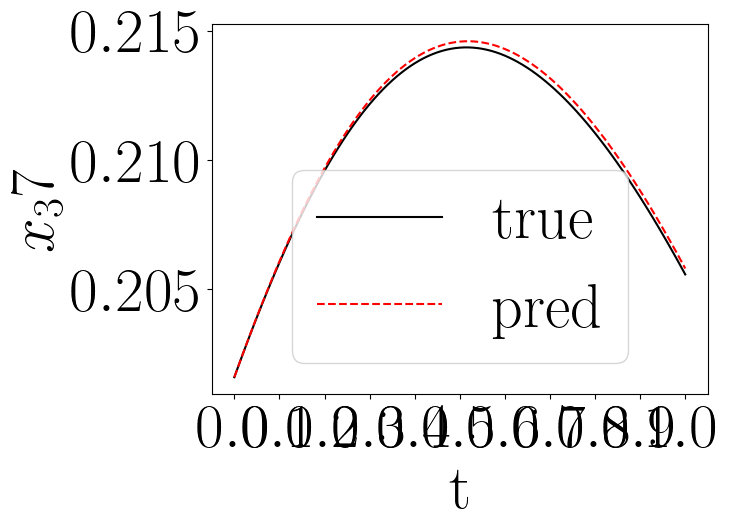

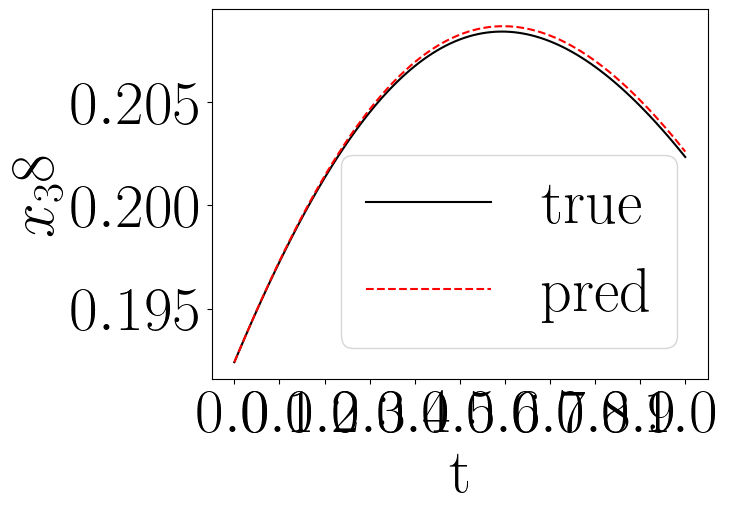

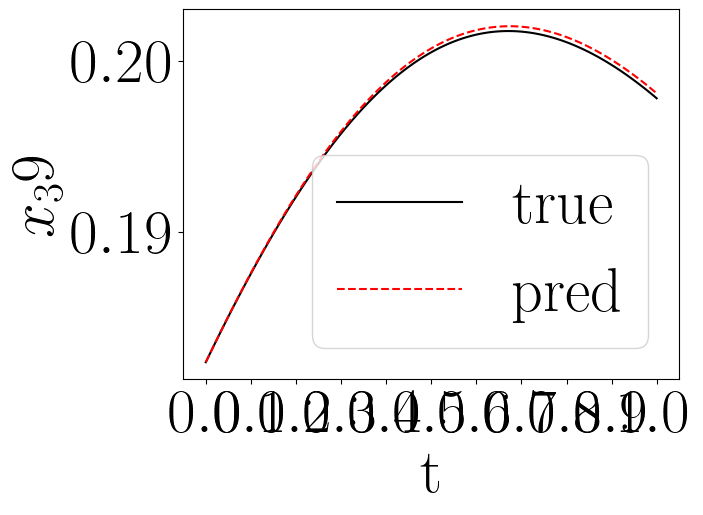

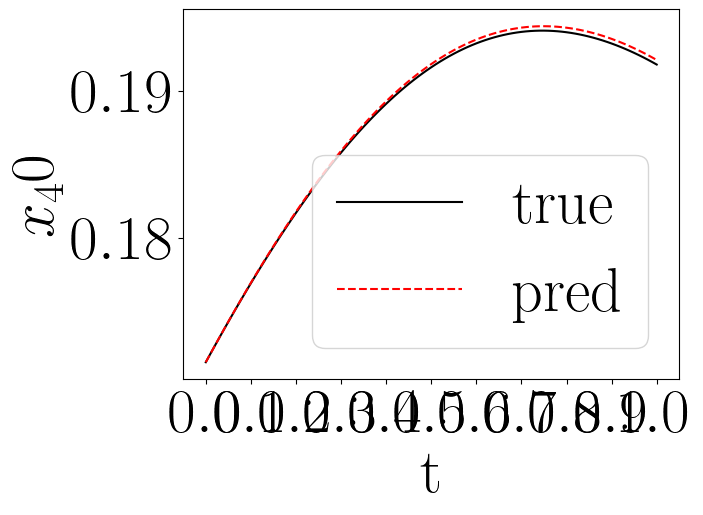

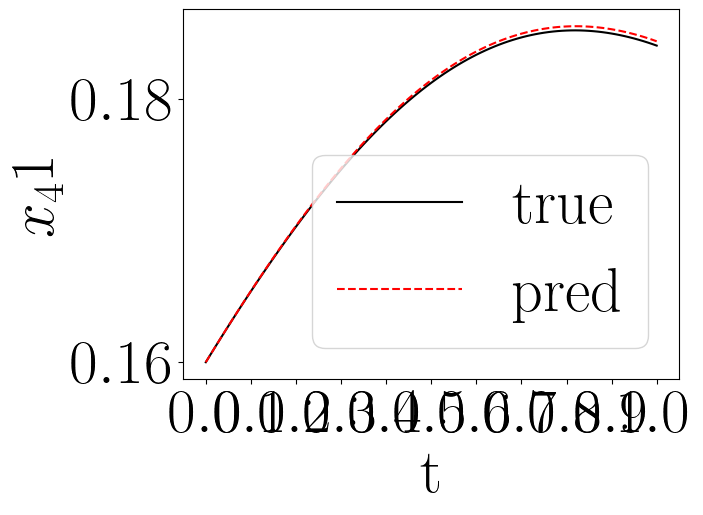

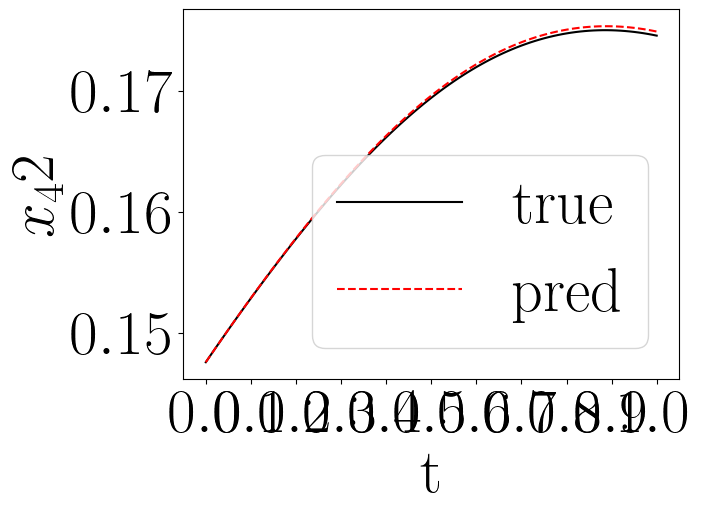

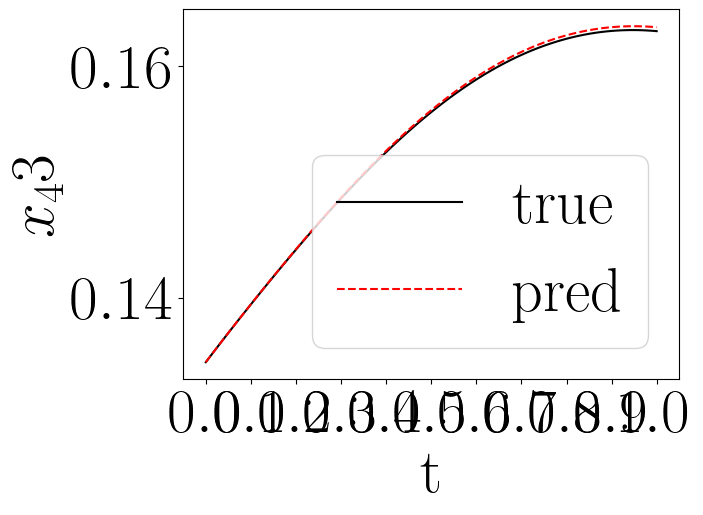

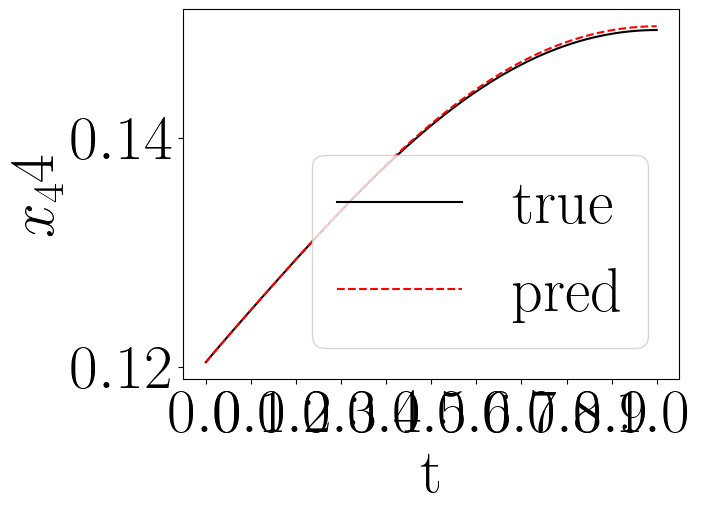

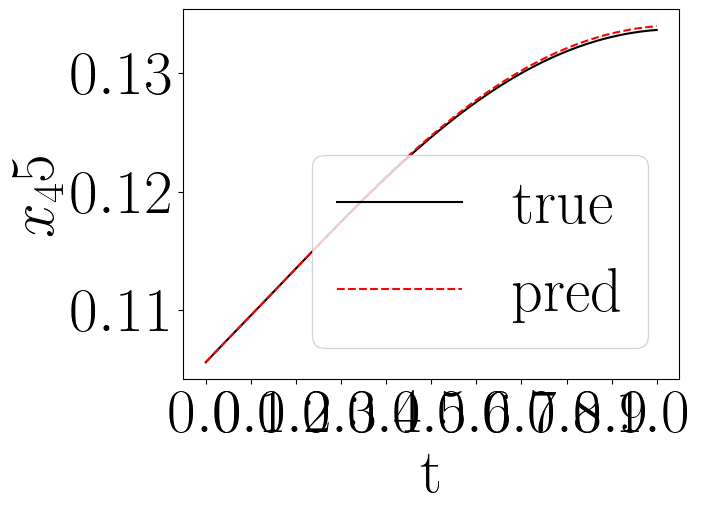

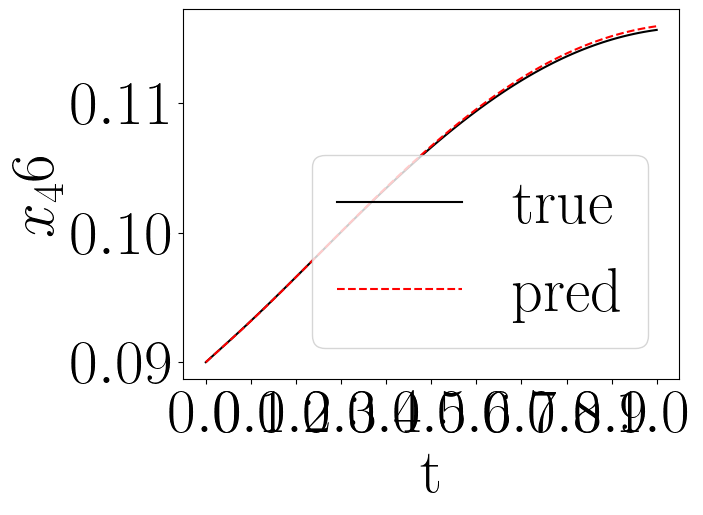

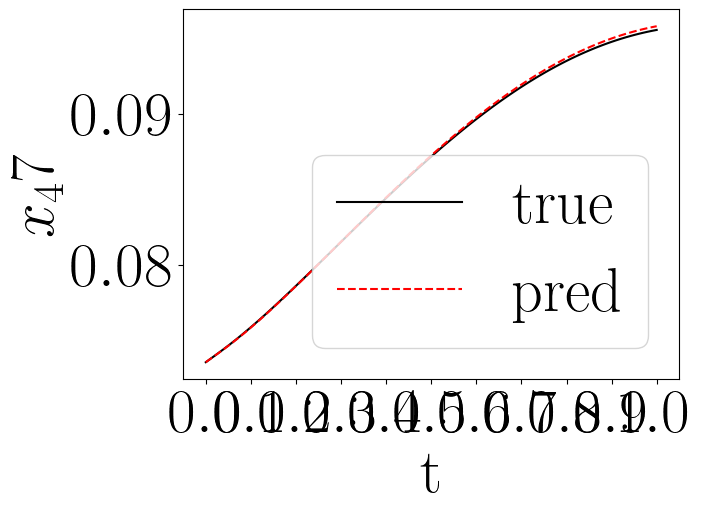

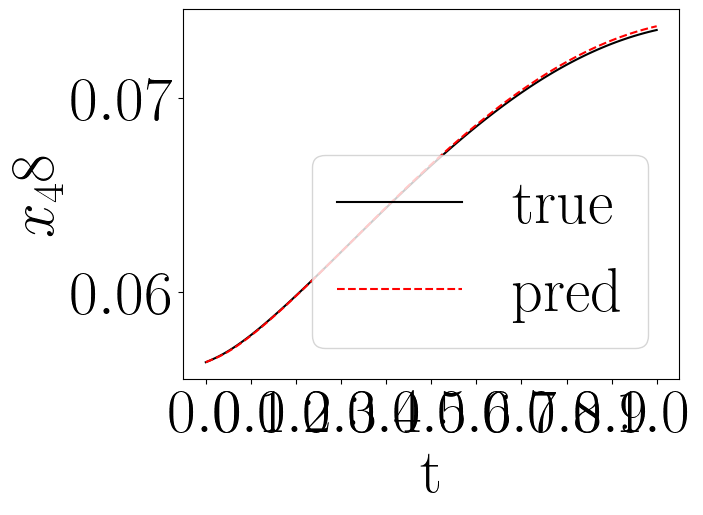

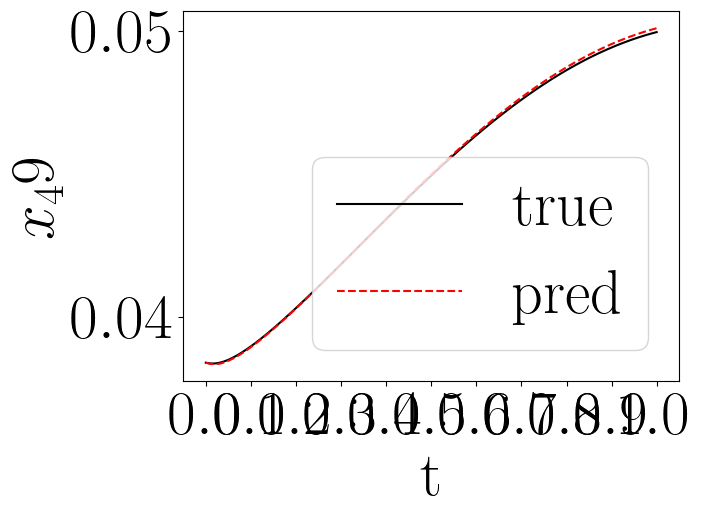

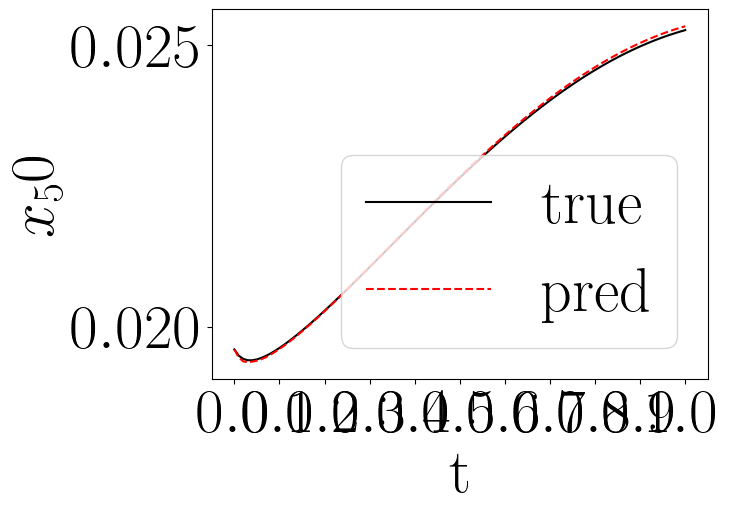

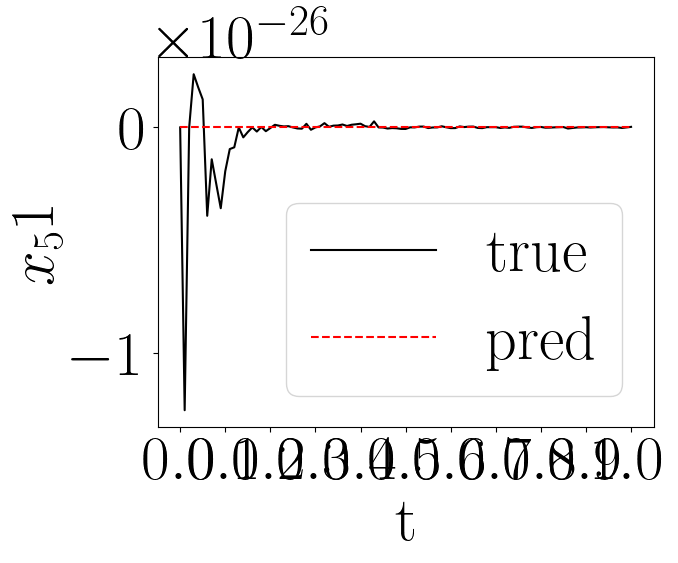

In [37]:
if system=="Burger":
    vec = vecRef

    for i in range(vec.N):
        fig = plt.figure()
        plt.plot(time_plot, output[:,i],'k-',label='true')
        plt.plot(time_plot, network_sol[i],'r--',label='pred')
        plt.xlabel("t")
        plt.ylabel(fr"$x_{i+1}$")
        plt.xticks(np.linspace(0,1,11))
        plt.legend()
        plt.show();